In [1]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from datetime import date, timedelta
import time
from google.colab import drive
drive.mount('/content/drive')
!pip install sweetviz
import sweetviz as sv

Mounted at /content/drive
     |████████████████████████████████| 15.1MB 8.4MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
train_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_err2.csv')
train_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_qui2.csv')
train_prob = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_prob2.csv')

test_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_err2.csv')
test_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_qui2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_qui2 = train_qui.copy()
test_qui2 = test_qui.copy()
train_err2 = train_err.copy()
test_err2 = test_err.copy()

# 퀼리티 3,4는 값이 1밖에 없어서 의미가 없기 때문에 제외
# 펌웨어 버전은 이미 err 자료에 있기 때문에 중복으로 제외
# 퀼리티 0은 EDA 결과 퀼리티 2와 피어슨 상관계수 0.99를 보이기 때문에 0과 2 중에 하나만 골랐음
# 0의 결측치 Nan은 15%고 2의 결측치는 4%기 때문에 결측치가 적은 2를 남기고 0은 drop 시킨다.

## 퀼리티 6과 7도 0.81로 강한 상관관계를 보이고 있는데, 하나를 제외해야 하나 고민이 됨
train_qui2.drop(['fwver','quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)
test_qui2.drop(['fwver', 'quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)

test_qui2 = test_qui2.replace(',','', regex=True)
train_qui2 = train_qui2.replace(',','', regex=True)
test_qui2.loc[:,'quality_1':'quality_12'] = test_qui2.loc[:,'quality_1':'quality_12'].astype(float)
train_qui2.loc[:,'quality_1':'quality_12'] = train_qui2.loc[:,'quality_1':'quality_12'].astype(float)

train_qui2['time'] = pd.to_datetime(train_qui['time'], format = '%Y-%m-%d %H:%M:%S')
test_qui2['time'] = pd.to_datetime(test_qui['time'], format = '%Y-%m-%d %H:%M:%S')

train_err2['time'] = pd.to_datetime(train_err2['time'], format = '%Y-%m-%d %H:%M:%S')
test_err2['time'] = pd.to_datetime(test_err2['time'], format = '%Y-%m-%d %H:%M:%S')
train_prob['time'] = pd.to_datetime(train_prob['time'], format = '%Y-%m-%d %H:%M:%S')

In [5]:
# 퀼리티 임계치
# [-1, 0, 1] == -1 카테고리 -1, -1~0 =카테고리 0, 그 이상 = 카테고리 1
qualities = {}

qualities['quality_1'] = [-1,0, 1]
qualities['quality_2'] = [-1,0, 1]
qualities['quality_5'] = [-1,0,1,2,4, 10]
qualities['quality_6'] = [-1,0, 1]
qualities['quality_7'] = [0,1,100, 101]
qualities['quality_8'] = [0,1,2]
qualities['quality_9'] = [0,1,2]
qualities['quality_10'] = [0,1,2,3, 4, 5,7, 10 ,14,15] ##??
qualities['quality_11'] = [-1,0,1]
qualities['quality_12'] = [0,1,2]

## 모델 임계치
## 모델 0,1,2,3,4의 비율을 더하면 99.999% 이므로, 모델 5~8은 other model로 통합하는 것이 바람직 해 보임.

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

In [7]:
def quality_categorize(dataset):
  data = dataset.copy()
  for key in tqdm(qualities):
    intervals = qualities.get(key)
    for i in range(len(intervals)):
      if intervals[i] == intervals[-1]:
        data[key][data[key] >= intervals[i]] =  intervals[i]
      # elif intervals[i+1] - intervals[i] == 1:
      #   continue
      else:
        data[key][(data[key] >= intervals[i]) & (data[key] < intervals[i+1])] = intervals[i]
  return data


In [8]:
train_qui3 = quality_categorize(train_qui2)
test_qui3 = quality_categorize(test_qui2)

In [9]:
train_err2['err'] =  1
train_prob['err'] = 1

In [10]:
import random

User_id = 10842


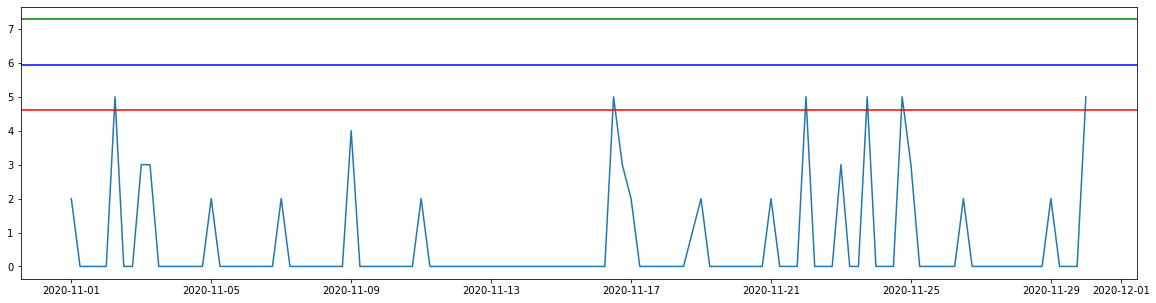

In [11]:
### 랜덤하게 한 명을 뽑아서 간격(interval)당 에러보고 횟수
## 빨간 점은 에러 리포트 시점! 없으면 에러 보고 안한 것

interval = '2h'  # 30분은 '30T', 4시간은 '4h' 등등
id = random.randint(10000,25000)
# err_type = 17
# temp = train_err2[train_err2.errtype == err_type]

temp = train_err2[train_err2['user_id']==id]
prob = train_prob[train_prob.user_id == id]
temp_time = temp.groupby(pd.Grouper(key = 'time', freq = '6h')).sum()
plt.figure(figsize=(20,5))
print('User_id = {}'.format(id))

m =  temp_time['err'].mean()
s = temp_time['err'].std()

UCL = m + 3*s
UCLL = UCL + s
UCLLL = UCL + 2*s

plt.plot(temp_time.index, temp_time.err)
plt.scatter(prob.time, prob.err, c = 'red', s = 300)
plt.axhline(y=UCL, color='r')
plt.axhline(y=UCLL, color='b')
plt.axhline(y=UCLLL, color='g')

# 12808, 12811, 13812
# 12810, 12812

User_id = 21829


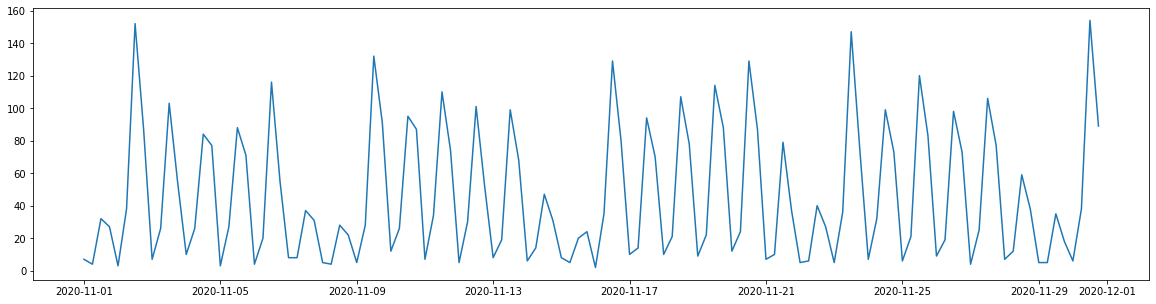

In [12]:
### 랜덤하게 한 명을 뽑아서 간격(interval)당 에러보고 횟수
## 빨간 점은 에러 리포트 시점! 없으면 에러 보고 안한 것

interval = '2h'  # 30분은 '30T', 4시간은 '4h' 등등
id = random.randint(10000,25000)
# err_type = 17
# temp = train_err2[train_err2.errtype == err_type]

temp_time = train_prob.groupby(pd.Grouper(key = 'time', freq = '6h')).sum()
plt.figure(figsize=(20,5))
print('User_id = {}'.format(id))

m =  temp_time['err'].mean()
s = temp_time['err'].std()

UCL = m + 3*s
UCLL = UCL + s
UCLLL = UCL + 2*s

plt.plot(temp_time.index, temp_time.err)

# 12808, 12811, 13812
# 12810, 12812

In [13]:
train_qui3['err'] = 1

User_id = 12041


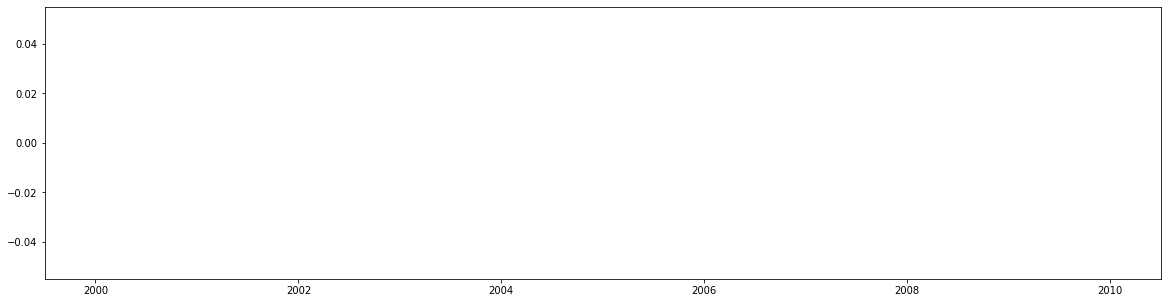

In [14]:
interval = '2h'  # 30분은 '30T', 4시간은 '4h' 등등
id = random.randint(10000,25000)
# err_type = 17
# temp = train_err2[train_err2.errtype == err_type]

temp = train_qui3[train_qui3['user_id']==id]
prob = train_prob[train_prob.user_id == id]
temp_time = temp.groupby(pd.Grouper(key = 'time', freq = '6h')).sum()
plt.figure(figsize=(20,5))
print('User_id = {}'.format(id))
plt.plot(temp_time.index, temp_time.err)
plt.scatter(prob.time, prob.err, c = 'red', s = 300)

# 12808, 12811, 13812
# 12810, 12812

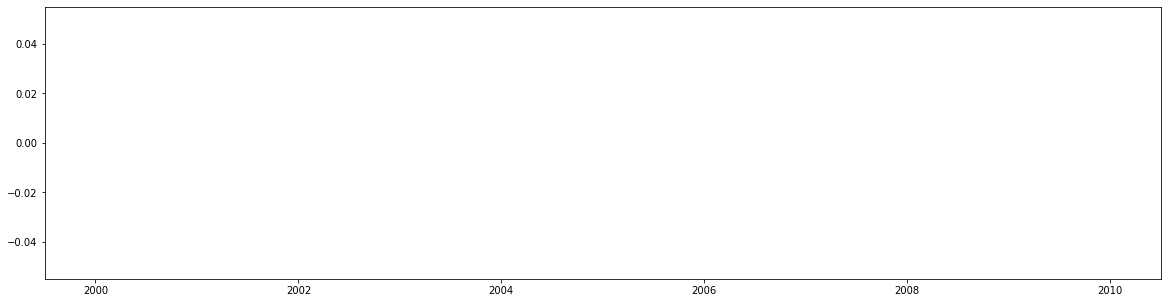

In [15]:
# 위의 버전에서 조금 업데이트
# err_type에 해당하는 에러들만 모아서 시간별 합계를 보여줌.

id = random.randint(10000,25000)
#err_type = [18,19,20,21,25, 34, 35]
err_type = [17]
temp = train_err2[train_err2.errtype.isin(err_type)]

temp = temp[temp['user_id']==id]
prob = train_prob[train_prob.user_id == id]
temp_time = temp.groupby(pd.Grouper(key = 'time', freq = '2h')).sum()
plt.figure(figsize=(20,5))
plt.plot(temp_time.index, temp_time.err)
plt.scatter(prob.time, prob.err, c = 'red', s = 300)

In [16]:
k = train_err2[train_err2.errtype.isin(err_type)]
len(k.user_id.unique())

5747

In [17]:
def err_by_time(dataset, fr = '12h'):
  data = dataset.copy()
  ids = data.user_id.unique()
  ids.sort()
  time_list = []
  data['err'] = 1
  for id in tqdm(ids):
    temp = data[data['user_id']==id]
    temp_time = temp.groupby(pd.Grouper(key = 'time', freq = fr)).sum()
    a = temp_time[['err']].mean().values[0]
    b = temp_time[['err']].std().values[0]

    m =  temp_time['err'].mean()
    s = temp_time['err'].std()

    UCL = m + 3*s
    UCLL = UCL + s
    UCLLL = UCL + 2*s

    c = len(temp_time[temp_time['err'] > UCL])
    d = len(temp_time[temp_time['err'] > UCLL])
    e = len(temp_time[temp_time['err'] > UCLLL])

    time_list.append([a,b,c,d,e])
  df = pd.DataFrame(time_list, index = ids, columns = ['mean', 'std', 'UCL', 'UCLL', 'UCLLL'])
  return df

In [ ]:
train_time = err_by_time(train_err2)
test_time = err_by_time(test_err2)
train_time = train_time.fillna(0)
test_time = test_time.fillna(0)

train_time.to_csv("트레인_err_12시간간격.csv")
test_time.to_csv("테스트_err_12시간간격.csv")
!cp 트레인_err_12시간간격.csv "drive/My Drive/"
!cp 테스트_err_12시간간격.csv "drive/My Drive/"

In [23]:
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()

In [148]:
### 랜덤하게 한 명을 뽑아서 간격(interval)당 에러보고 횟수
## 빨간 점은 에러 리포트 시점! 없으면 에러 보고 안한 것

def time_step(dataset):

  data = dataset.copy()
  data['err'] = 1
  interval = '2h'  # 30분은 '30T', 4시간은 '4h' 등등
  ids = list(data['user_id'].unique())
  ids.sort()
  test = pd.DataFrame()

  for id in tqdm(ids):

    temp = data[data['user_id']==id]
    temp_time = temp.groupby(pd.Grouper(key = 'time', freq = interval)).sum()
    temp_time.rename(columns= {'err' : id}, inplace=True)
    test = pd.concat([test, temp_time[id]], axis = 1)

  test.fillna(0, inplace=True)
  return test

In [149]:
temps = time_step(train_err2)
temps_test = time_step(test_err2)

In [150]:
temp_train = np.log(temps+1)
temp_test = np.log(temps_test + 1)

In [151]:
train = temp_train.to_numpy().reshape(-1,1)
test = temp_test.to_numpy().reshape(-1,1)

In [152]:
train_time_series = pd.DataFrame(robust.fit_transform(train).reshape(len(temps), -1), columns = temps.columns, index = temps.index)
test_time_series = pd.DataFrame(robust.transform(test).reshape(len(temps_test), -1), columns = temps_test.columns, index = temps_test.index)

In [153]:
train_time_series2 = train_time_series.transpose()
test_time_series2 = test_time_series.iloc[:129,:].transpose()

In [169]:
train_time_series2

,2020-10-31 18:00:00,2020-11-01 00:00:00,2020-11-01 06:00:00,2020-11-01 12:00:00,2020-11-01 18:00:00,2020-11-02 00:00:00,2020-11-02 06:00:00,2020-11-02 12:00:00,2020-11-02 18:00:00,2020-11-03 00:00:00,2020-11-03 06:00:00,2020-11-03 12:00:00,2020-11-03 18:00:00,2020-11-04 00:00:00,2020-11-04 06:00:00,2020-11-04 12:00:00,2020-11-04 18:00:00,2020-11-05 00:00:00,2020-11-05 06:00:00,2020-11-05 12:00:00,2020-11-05 18:00:00,2020-11-06 00:00:00,2020-11-06 06:00:00,2020-11-06 12:00:00,2020-11-06 18:00:00,2020-11-07 00:00:00,2020-11-07 06:00:00,2020-11-07 12:00:00,2020-11-07 18:00:00,2020-11-08 00:00:00,2020-11-08 06:00:00,2020-11-08 12:00:00,2020-11-08 18:00:00,2020-11-09 00:00:00,2020-11-09 06:00:00,2020-11-09 12:00:00,2020-11-09 18:00:00,2020-11-10 00:00:00,2020-11-10 06:00:00,2020-11-10 12:00:00,...,2020-11-23 12:00:00,2020-11-23 18:00:00,2020-11-24 00:00:00,2020-11-24 06:00:00,2020-11-24 12:00:00,2020-11-24 18:00:00,2020-11-25 00:00:00,2020-11-25 06:00:00,2020-11-25 12:00:00,2020-11-25 18:00:00,2020-11-26 00:00:00,2020-11-26 06:00:00,2020-11-26 12:00:00,2020-11-26 18:00:00,2020-11-27 00:00:00,2020-11-27 06:00:00,2020-11-27 12:00:00,2020-11-27 18:00:00,2020-11-28 00:00:00,2020-11-28 06:00:00,2020-11-28 12:00:00,2020-11-28 18:00:00,2020-11-29 00:00:00,2020-11-29 06:00:00,2020-11-29 12:00:00,2020-11-29 18:00:00,2020-11-30 00:00:00,2020-11-30 06:00:00,2020-11-30 12:00:00,2020-11-30 18:00:00,2020-12-01 00:00:00,2020-12-01 06:00:00,2020-12-01 12:00:00,2020-12-01 18:00:00,2020-12-02 00:00:00,2020-12-02 06:00:00,2020-12-02 12:00:00,2020-12-02 18:00:00,Group,problems
10000,-0.63093,0.315465,-0.315465,0.000000,-0.630930,0.184535,-0.315465,-0.630930,0.000000,0.315465,-0.315465,0.460399,-0.630930,-0.630930,-0.630930,0.101557,-0.315465,0.254692,-0.315465,-0.630930,0.000000,0.369070,-0.315465,-0.630930,-0.630930,-0.130930,0.460399,0.101557,0.101557,0.101557,0.000000,-0.630930,-0.630930,-0.130930,0.000000,-0.630930,-0.630930,0.417022,-0.315465,-0.630930,...,-0.630930,-0.630930,-0.315465,0.101557,-0.630930,-0.630930,0.184535,-0.315465,-0.630930,0.000000,0.315465,-0.315465,-0.630930,0.000000,0.315465,-0.315465,-0.630930,0.101557,0.369070,-0.315465,-0.630930,0.417022,0.315465,0.254692,-0.630930,-0.630930,0.101557,-0.315465,-0.630930,0.101557,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,1,False
10001,-0.63093,0.369070,-0.630930,-0.630930,0.000000,0.709142,0.536429,0.536429,0.369070,-0.315465,0.630930,0.315465,0.254692,-0.130930,0.901593,-0.630930,0.709142,0.570157,-0.630930,0.658521,0.570157,0.101557,0.184535,0.658521,0.101557,0.254692,-0.630930,0.101557,0.000000,0.000000,-0.630930,0.369070,0.570157,0.775864,-0.630930,0.184535,0.885622,0.684535,0.184535,0.684535,...,0.369070,0.000000,0.184535,0.315465,0.184535,0.460399,-0.130930,0.101557,-0.315465,0.101557,0.369070,0.658521,0.601557,0.754692,-0.630930,0.796095,2.433031,2.275097,0.254692,0.417022,0.315465,0.658521,0.709142,0.709142,0.684535,0.417022,0.500000,0.101557,0.184535,0.369070,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,2,True
10002,-0.63093,-0.130930,0.101557,-0.630930,0.101557,-0.315465,0.254692,-0.315465,0.184535,0.000000,-0.630930,-0.630930,0.460399,-0.315465,0.101557,0.184535,0.184535,-0.130930,0.000000,-0.315465,0.000000,0.101557,-0.315465,-0.630930,0.000000,0.000000,0.254692,0.254692,-0.130930,-0.315465,-0.630930,0.254692,0.101557,0.000000,0.369070,-0.315465,-0.630930,-0.630930,-0.630930,0.184535,...,-0.630930,-0.630930,-0.630930,-0.630930,-0.630930,0.254692,0.000000,0.184535,-0.630930,0.000000,-0.315465,-0.630930,-0.630930,0.101557,0.315465,0.184535,-0.630930,0.101557,-0.630930,-0.630930,-0.630930,-0.630930,-0.130930,0.101557,-0.630930,-0.130930,-0.315465,0.101557,-0.315465,0.000000,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,-0.63093,1,False
10003,-0.63093,-0.630930,-0.630930,-0.630930,0.417022,0.254692,0.101557,-0.630930,0.101557,0.101557,0.000000,-0.630930,0.000000,-0.630930,-0.130930,-0.630930,0.000000,0.0000

In [168]:
train_time_series2.max().max()

6

In [166]:
train_time_series2.to_csv("트레인_err_시계열.csv")
test_time_series2.to_csv("테스트_err_시계열.csv")
!cp 트레인_err_시계열.csv "drive/My Drive/"
!cp 테스트_err_시계열.csv "drive/My Drive/"

In [ ]:
train_time.to_csv("트레인_err_2시간간격.csv")
test_time.to_csv("테스트_err_2시간간격.csv")
!cp 트레인_err_2시간간격.csv "drive/My Drive/"
!cp 테스트_err_2시간간격.csv "drive/My Drive/"

In [103]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7efed45adc18>,
                 k=None, metric=None, model=None, timings=True)

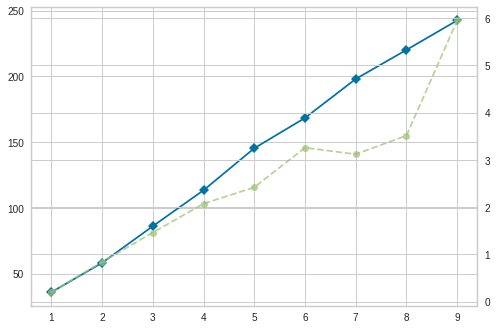

In [111]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(train_time_series2.values)

In [155]:
inertia_arr = []
k_range = range(2,30)

for k in k_range:
  ks = KMeans(n_clusters = k, random_state = 42)
  ks.fit(train_time_series2)
  ins = ks.inertia_

  inertia_arr.append(ins)

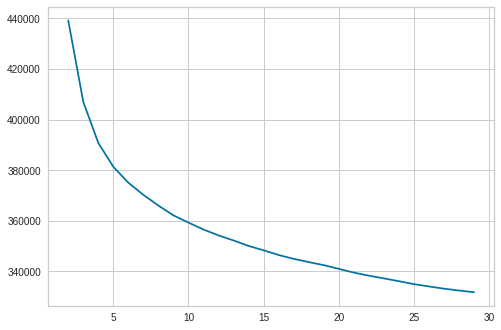

In [157]:
plt.plot(k_range, inertia_arr)

In [163]:
ks = KMeans(n_clusters = 7, random_state = 42)
ks.fit(train_time_series2)
train_time_series2['Group'] = ks.predict(train_time_series2)
train_time_series2['problems'] = train_time_series2.index.isin(prob_list)

In [164]:
for i in range(7):
  print(i)
  ori = train_time_series2[train_time_series2['Group'] == i]
  pro = ori[ori['problems']]
  print(len(ori))
  print(len(pro) / len(ori))

0
1729
0.5043377674956623
1
3137
0.25916480714058016
2
1961
0.4273329933707292
3
2809
0.37807048771804913
4
2645
0.1553875236294896
5
774
0.5387596899224806
6
1945
0.3017994858611825


In [144]:
for i in range(10):
  print(i)
  ori = train_time_series2[train_time_series2['Group'] == i]
  pro = ori[ori['problems']]
  print(len(ori))
  print(len(pro) / len(ori))

0
1482
0.300944669365722
1
1447
0.38286109191430545
2
1672
0.11483253588516747
3
259
0.5096525096525096
4
2157
0.22716736207695873
5
2190
0.28036529680365296
6
1760
0.42329545454545453
7
843
0.5492289442467378
8
1689
0.3635287152161042
9
1501
0.4996668887408394


In [127]:
temp = temp.fillna(0)
prob_list = train_prob['user_id'].unique()
prob_list.sort()

In [ ]:
temp = temp.reset_index()

In [ ]:
temp['problems'] = temp['index'].isin(prob_list)
temp = temp.set_index('index')

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

temp.iloc[:,:2] = scaler.fit_transform(temp.iloc[:,:2])

In [ ]:
temp_tr = temp[temp['problems']]
temp_fls = temp[temp['problems'] != True]

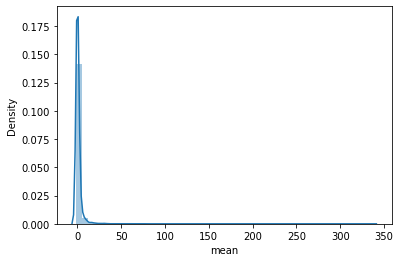

In [ ]:
sns.distplot(temp_tr['mean'])

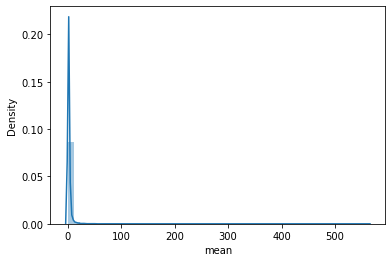

In [ ]:
sns.distplot(temp_fls['mean'])

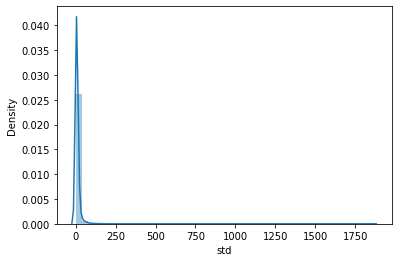

In [ ]:
sns.distplot(temp_tr['std'])

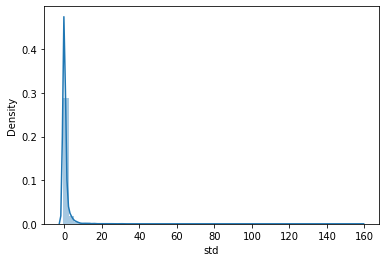

In [ ]:
sns.distplot(temp_fls['std'])

In [ ]:
temp_tr['std'].max()

1858.7845309261313

In [ ]:
train_err3 = train_err2[['user_id', 'model_nm', 'errtype', 'errcode', 'time']]
test_err3 = test_err2[['user_id', 'model_nm', 'errtype', 'errcode', 'time']]

In [ ]:
# 에러 코드의 분포는 다음과 같다.

print(train_err2.errcode.value_counts())
# 중간에 나오다가 잘리지만.. 전에 발간한 리포트를 보면 상위 15개 에러가 99.9%를 차지하고 있다.
# 따라서 상위 15개는 각각의 카테고리로 주고, 나머지는 16번째 '기타' 카테고리로 묶으면 어떨까 싶습니다.
# 상위 15개 리스트
err_code =['1','0','connection timeout','B-A8002','80','79','14','active','2','84','85','standby','NFANDROID2','connection fail to establish','3']

# 위의 15개에 포함되지 않는 에러코드는 걍 'etc'로 분류
train_err3['errcode'][~train_err3['errcode'].isin(err_code)] = 'ETC'
test_err3['errcode'][~train_err3['errcode'].isin(err_code)] = 'ETC'


## 에러타입은 어차피 41개 뿐이라... 분포도 고른 편 같고... 얌전히 두기로 함.

1                     8906967
0                     2599123
connection timeout    1835600
B-A8002                897863
80                     334018
                       ...   
8019                        1
3755                        1
184780                      1
25957                       1
9181                        1
Name: errcode, Length: 2805, dtype: int64


In [ ]:
train_err4 = train_err3.copy()

In [ ]:
train_err4['hour'] = train_err4['time'].dt.hour
train_err4['weekday'] = train_err4['time'].dt.weekday

In [ ]:
train_err4['problems'] = train_err4.user_id.isin(prob_list)
train_err4_tr = train_err4[train_err4['problems']]
train_err4_fls = train_err4[train_err4['problems'] != True]

In [ ]:
train_err4_tr

,user_id,model_nm,errtype,errcode,time,hour,weekday,problems
317,10001,model_2,15,1,2020-11-01 02:04:15,2,6,True
318,10001,model_2,15,1,2020-11-01 02:04:15,2,6,True
319,10001,model_2,31,1,2020-11-01 02:04:15,2,6,True
320,10001,model_2,33,2,2020-11-01 02:04:15,2,6,True
321,10001,model_2,12,1,2020-11-01 02:04:21,2,6,True
...,...,...,...,...,...,...,...,...
16554088,24998,model_0,15,1,2020-11-29 05:08:46,5,6,True
16554089,24998,model_0,16,1,2020-11-30 13:26:04,13,0,True
16554090,24998,model_0,31,0,2020-11-30 13:26:24,13,0,True
16554091,24998,model_0,40,1,2020-11-30 21:03:51,21,0,True


In [ ]:
tr = pd.DataFrame(train_err4_tr['errtype'].value_counts().sort_index())
all = pd.DataFrame(train_err4['errtype'].value_counts().sort_index())

In [ ]:
tr.transpose()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42
errtype,4016,9310,13940,363153,423956,28187,30025,28,54,96989,126391,132926,16363,125541,640140,513531,21257,2339,554,1809,506,964736,1250243,17646,1060,202030,294144,294513,281,868235,538238,69366,122748,7406,3860,3874,2349,8819,327526,48787,11905


In [ ]:
k = tr/all
k.transpose()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42
errtype,0.186401,0.356623,0.453215,0.280049,0.444902,0.558357,0.577482,0.168675,0.495413,0.727038,0.411657,0.415159,0.716324,0.498149,0.398853,0.41103,0.462018,0.875702,0.834337,0.869712,0.833608,0.517185,0.549192,0.451639,0.89527,0.37664,0.543901,0.54108,0.699005,0.437333,0.476079,0.388655,0.741518,0.727005,0.414296,0.414953,0.517515,0.557459,0.448434,0.468484,0.346337


In [ ]:
train_err3

,user_id,model_nm,errtype,errcode,time
0,10000,model_3,15,1,2020-11-01 02:56:16
1,10000,model_3,12,1,2020-11-01 03:03:09
2,10000,model_3,11,1,2020-11-01 03:03:09
3,10000,model_3,16,1,2020-11-01 05:05:14
4,10000,model_3,4,0,2020-11-01 05:05:15
...,...,...,...,...,...
16554658,24999,model_3,15,1,2020-11-30 16:30:51
16554659,24999,model_3,16,1,2020-11-30 17:26:25
16554660,24999,model_3,4,0,2020-11-30 17:26:25
16554661,24999,model_3,4,0,2020-11-30 17:26:31


In [ ]:
pd.get_dummies(train_err3['errcode'])

,0,1,14,2,3,79,80,84,85,B-A8002,ETC,NFANDROID2,active,connection fail to establish,connection timeout,standby
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16554658,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16554659,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16554660,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16554661,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
